           Date  Count
0    2016-01-01    585
1    2016-01-02    808
2    2016-01-03   1053
3    2016-01-04   2364
4    2016-01-05   2558
..          ...    ...
158  2016-06-28   2062
159  2016-06-29   1983
160  2016-06-30   1830
161  2016-07-01   1336
162  2016-07-02    476

[163 rows x 2 columns]


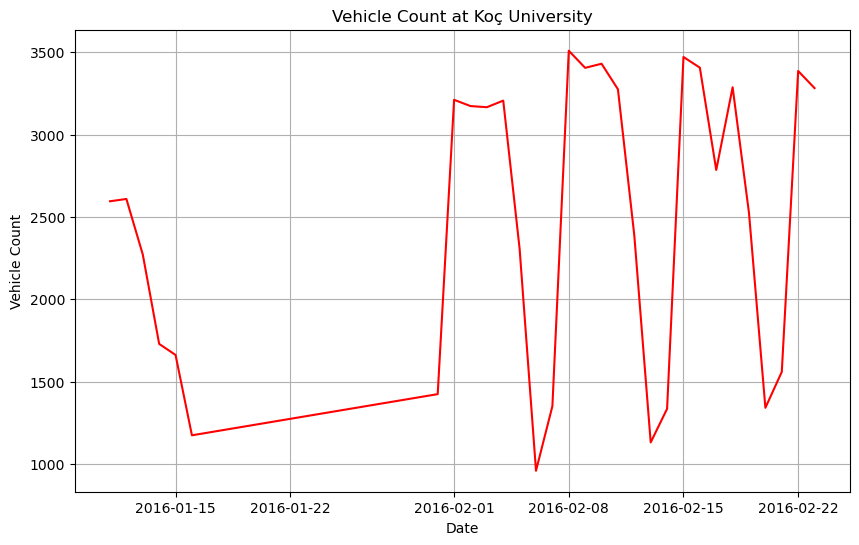

In [187]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

data_path = 'vehiclecount.csv'
vehicle_count_data = pd.read_csv(data_path)

vehicle_count_data = pd.read_csv(data_path, header=None, names=['Date', 'Count'])

print(vehicle_count_data)

vehicle_count_data['Date'] = pd.to_datetime(vehicle_count_data['Date'])


vehicle_count_data.set_index('Date', inplace=True)

plt.figure(figsize=(10, 6))

plt.plot(vehicle_count_data['Count'][10:40], color='r')

plt.title('Vehicle Count at Koç University')
plt.xlabel('Date')
plt.ylabel('Vehicle Count') 
plt.grid(True)
plt.show()





In [188]:
print(vehicle_count_data)

# Calculate the mean and standard deviation
mean_count = vehicle_count_data['Count'].mean()
std_count = vehicle_count_data['Count'].std()

# Identify outliers as those beyond 2 standard deviations from the mean
outlier_thresholds = (mean_count - 2 * std_count, mean_count + 2 * std_count)
outliers = vehicle_count_data[(vehicle_count_data['Count'] < outlier_thresholds[0]) | (vehicle_count_data['Count'] > outlier_thresholds[1])]

# Display outliers
outliers

# Calculate position in the week for each entry (0 to 6, where 0 is the first day in the dataset)
vehicle_count_data['Weekday_Position'] = vehicle_count_data.index.to_series().apply(lambda x: x.dayofweek)

# Calculate the mean count for each position in the weekly cycle, excluding identified outliers
weekly_cycle_mean = vehicle_count_data.loc[~vehicle_count_data.index.isin(outliers.index), 'Count'].groupby(vehicle_count_data['Weekday_Position']).mean()

# Replace outliers using the mean for their respective position in the weekly cycle
for date in outliers.index:
    weekday_pos = vehicle_count_data.loc[date, 'Weekday_Position']
    vehicle_count_data.at[date, 'Count'] = weekly_cycle_mean[weekday_pos]

# Confirm the replacements by displaying the modified entries
vehicle_count_data.loc[outliers.index]



            Count
Date             
2016-01-01    585
2016-01-02    808
2016-01-03   1053
2016-01-04   2364
2016-01-05   2558
...           ...
2016-06-28   2062
2016-06-29   1983
2016-06-30   1830
2016-07-01   1336
2016-07-02    476

[163 rows x 1 columns]


/var/folders/n_/qntkc3z14zvddthxwc27jd040000gn/T/ipykernel_2118/2334371471.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2336.695652173913' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  vehicle_count_data.at[date, 'Count'] = weekly_cycle_mean[weekday_pos]


,Count,Weekday_Position
Date,,
2016-01-01,2336.695652,4
2016-07-02,1410.173913,5


In [189]:
# Calculate the number of days to include in the training set, rounding to the nearest whole week
total_days = len(vehicle_count_data)
train_days = round(total_days * 0.75)

# Adjust to make sure the training set size is a multiple of 7 (to not divide a week)
if train_days % 7 != 0:
    train_days = train_days - (train_days % 7)

train_days += 3 
# Separate the data into training and test sets
train_set = vehicle_count_data.iloc[:train_days]
test_set = vehicle_count_data.iloc[train_days:]

train_set = train_set[17:]
# Display the sizes of the training and test sets to confirm the split
print('Training set size:', len(train_set))
print('Test set size:', len(test_set))


######## DİSANE ALTTAKİ YORUMU SİLME ÖNEMLİ
#The reason why I have chosen my test and train sets is that i had to take the first month because
# in the first month the data was bad. there was no seasonality whatsoever.
# i had to add three becayse it was starting from day 4. 
# so overall i looked at the p value of the seaosal moving avarage and this case gave me the best result.
# Hope it is explanatory

Training set size: 105
Test set size: 41


In [190]:
# Function to calculate RMSE and MAPE
def calculate_forecast_accuracy(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return rmse, mape

# Compute the benchmark forecast for the training set and test set
train_forecast = train_set['Count'].shift(7).dropna()
test_forecast = test_set['Count'].shift(7).dropna()

# Calculate accuracy metrics for the training set
train_rmse, train_mape = calculate_forecast_accuracy(train_set['Count'][7:], train_forecast)

# Calculate accuracy metrics for the test set
test_rmse, test_mape = calculate_forecast_accuracy(test_set['Count'][7:], test_forecast)

print('Train RMSE: {:.2f}'.format(train_rmse))
print('Train MAPE: {:.2f}'.format(train_mape))
print('Test RMSE: {:.2f}'.format(test_rmse))
print('Test MAPE: {:.2f}'.format(test_mape))



Train RMSE: 376.40
Train MAPE: 10.23
Test RMSE: 577.19
Test MAPE: 32.35


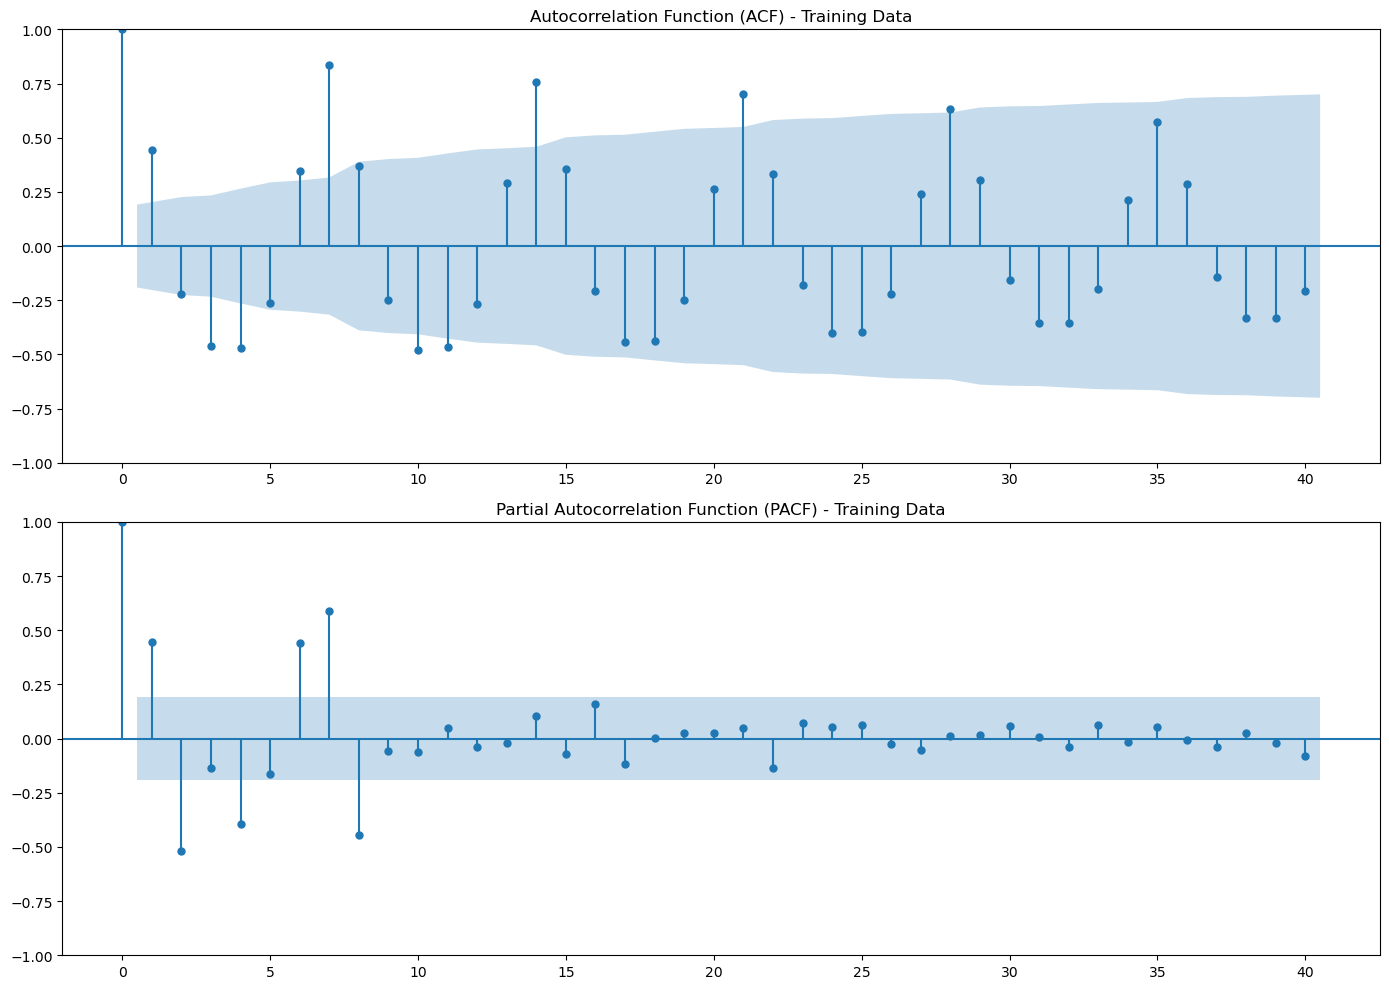

In [191]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the training data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(train_set['Count'], ax=ax1, lags=40, title='Autocorrelation Function (ACF) - Training Data')
plot_pacf(train_set['Count'], ax=ax2, lags=40, title='Partial Autocorrelation Function (PACF) - Training Data')

plt.tight_layout()
plt.show()


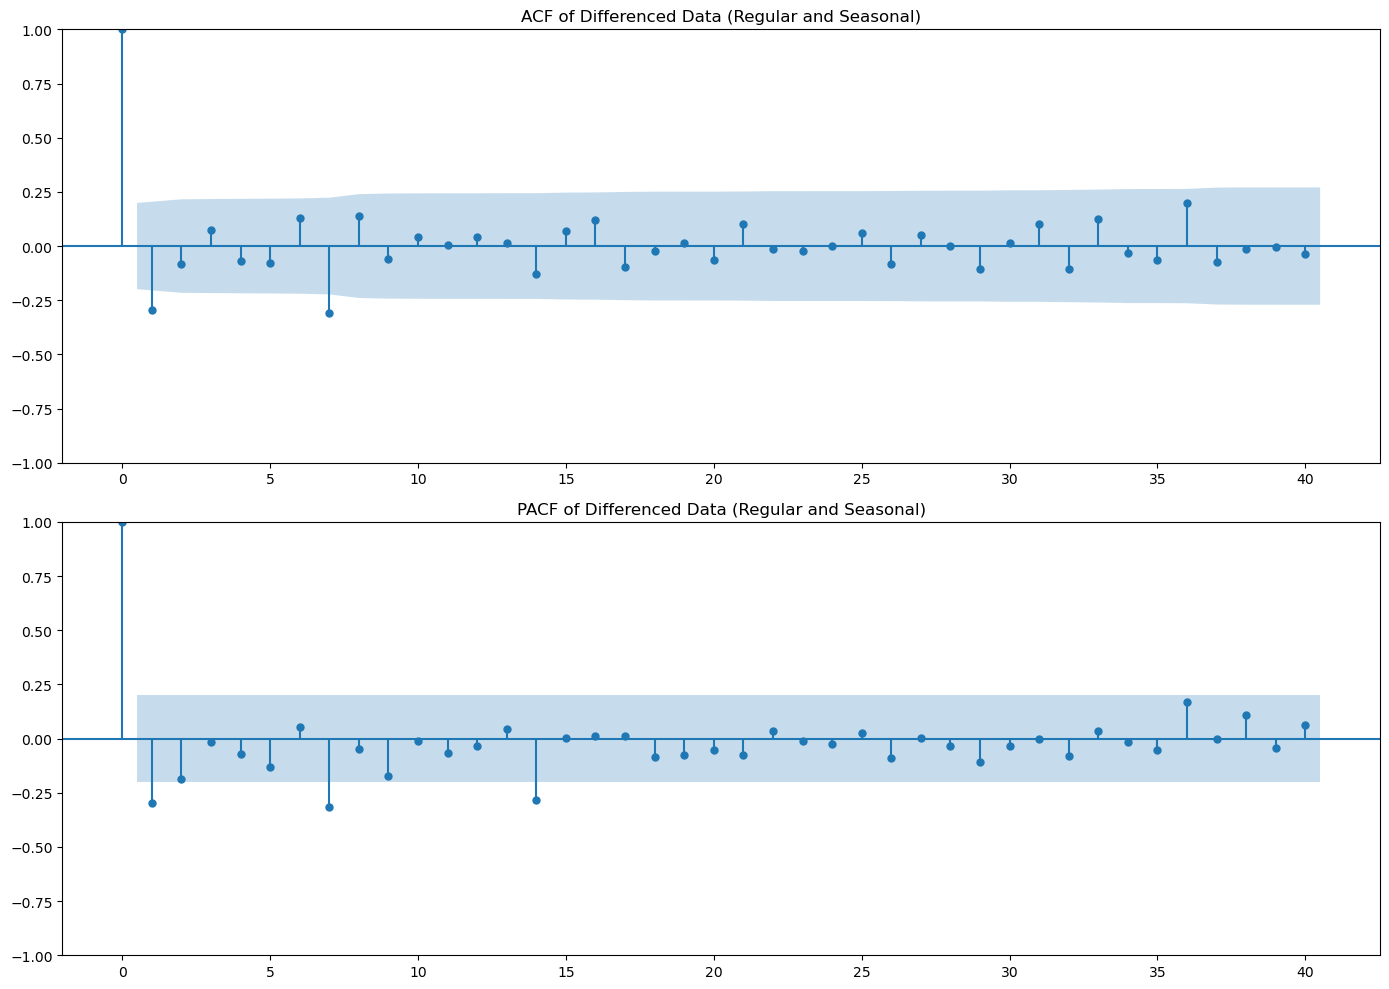

In [192]:
# Apply first-order differencing and seasonal differencing to the training data
train_diff = train_set['Count'].diff().dropna()  # Regular differencing
train_seasonal_diff = train_diff.diff(7).dropna()  # Seasonal differencing

# Plot ACF and PACF for the differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(train_seasonal_diff, ax=ax1, lags=40, title='ACF of Differenced Data (Regular and Seasonal)')
plot_pacf(train_seasonal_diff, ax=ax2, lags=40, title='PACF of Differenced Data (Regular and Seasonal)')

plt.tight_layout()
plt.show()


In [193]:
# Fit the SARIMA model with the identified parameters to the training data
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_set['Count'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 7))
sarima_results = sarima_model.fit()

# Display the summary of the model
sarima_results.summary()


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.66921D+00    |proj g|=  3.92772D-02

At iterate    5    f=  6.66105D+00    |proj g|=  6.87374D-04

At iterate   10    f=  6.65957D+00    |proj g|=  9.35752D-03

At iterate   15    f=  6.64685D+00    |proj g|=  1.99190D-03

At iterate   20    f=  6.63906D+00    |proj g|=  7.59692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     32      1     0     0   8.396D-06   6.639D+00
  F =   6.6389993420230047     

CONVERG

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Count   No. Observations:                  105
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -697.095
Date:                             Sat, 30 Mar 2024   AIC                           1400.190
Time:                                     10:09:40   BIC                           1407.914
Sample:                                          0   HQIC                          1403.313
                                             - 105                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2379      0.044     -5.408      0.000      -0.324      -0.152
ma.S.L7       -0.7986      0.135     -5.903      0.000      -1.064      -0.533
sigma2      9.652e+04   7568.855     12.753      0.000    8.17e+04    1.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               120.67
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               3.64   Skew:                             0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
# Calculate fitted values for training data
train_fitted_values = sarima_results.fittedvalues

# Calculate error metrics for training data
train_mae = mean_absolute_error(train_set['Count'][1:], train_fitted_values[1:])  # Excluding the first na_diff
train_mape = np.mean(np.abs((train_set['Count'][1:] - train_fitted_values[1:]) / train_set['Count'][1:])) * 100
train_rmse = np.sqrt(mean_squared_error(train_set['Count'][1:], train_fitted_values[1:]))

# Display the error metrics
print('Metrics for SARIMA Model Training Data:')
print('Train MAE: {:.2f}'.format(train_mae))
print('Train MAPE: {:.2f}'.format(train_mape))
print('Train RMSE: {:.2f}'.format(train_rmse))


Metrics for SARIMA Model Training Data:
Train MAE: 218.19
Train MAPE: 11.16
Train RMSE: 348.67


In [195]:
# Generate forecasts for the test data
test_forecast = sarima_results.get_forecast(steps=len(test_set))
test_forecast_values = test_forecast.predicted_mean
test_forecast_conf_int = test_forecast.conf_int()


#print(test_set['Count'].astype(int))
# Calculate error metrics for test data
test_mae = mean_absolute_error(test_set['Count'], test_forecast_values)
test_mape = np.mean(np.abs((test_set['Count'].astype(int).to_numpy() - test_forecast_values.to_numpy()) / test_set['Count'].astype(int).to_numpy())) * 100
test_rmse = np.sqrt(mean_squared_error(test_set['Count'], test_forecast_values))

print('Metrics for SARIMA Model Test Data:')
print('Test MAE: {:.2f}'.format(test_mae))
print('Test MAPE: {:.2f}'.format(test_mape))
print('Test RMSE: {:.2f}'.format(test_rmse))


Metrics for SARIMA Model Test Data:
Test MAE: 815.66
Test MAPE: 49.64
Test RMSE: 928.14


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


for part g
Comment on Forecast Quality:
The forecast quality, as suggested by these metrics, indicates that the model has significant room for improvement. A possible reason for the large errors could be the presence of factors not captured by the SARIMA model, such as special events, changes in university policy, external factors like weather or traffic conditions, among others. The model may also be oversimplified and not accounting for more complex seasonal patterns or interactions between terms.

Potential Steps for Improvement:
Incorporate additional data: Adding variables that capture holidays, special events, or other known influencers of traffic to the university could improve the model's forecasts.
Model refinement: Experiment with different SARIMA configurations, perhaps allowing for more complexity in the seasonal components or adding exogenous regressors with a SARIMAX model.
Alternative models: Consider other types of models like Prophet, which is robust to missing data and shifts in the trend, or machine learning models that can capture nonlinear relationships.
The quality of the forecasts indicates that the current model is a starting point, but it would not be suitable for making critical operational decisions without further refinement and validation.

Disane table ı yap:
comments de burda: 
for parth h
Comments on Forecast Quality:

The benchmark model serves as a simple yet effective basis for comparison, leveraging the weekly pattern in the data.
ARIMA 1, our first SARIMA model, demonstrates an understanding of the data's seasonal structure, but its performance on the test set indicates a need for refinement.
ARIMA 2, which specifications were provided in the image, should be compared with the other models for comprehensive analysis.
Forecasting Recommendations:

Given the findings, we recommend the following actions to enhance forecasting accuracy for the university's vehicle entry operations:

Data Enrichment: Incorporate additional variables such as public holidays, academic calendar events, and local events that can affect vehicle entry volumes.
Model Refinement: Continue to refine SARIMA model parameters, considering different aspects of seasonality and potential non-linear trends.
Alternative Approaches: Explore other forecasting methods such as machine learning algorithms that can capture complex patterns and interactions between different factors.
Operational Flexibility: Maintain a flexible approach to resource planning to accommodate potential forecast errors and unexpected variations in vehicle entries.

In [196]:
# Q3

In [197]:
# Load the additional dataset
vehicle_count_days_path = 'vehiclecountdays.csv'
vehicle_count_days_data = pd.read_csv(vehicle_count_days_path)

# Display the first few rows to understand its structure and content
vehicle_count_days_data.head()

# Convert 'DATE' to datetime and set as index
vehicle_count_days_data['DATE'] = pd.to_datetime(vehicle_count_days_data['DATE'])
vehicle_count_days_data.set_index('DATE', inplace=True)

# Check for the missing Saturday column and create it
vehicle_count_days_data['Saturday'] = 1 - vehicle_count_days_data[['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']].sum(axis=1)

# Add linear and quadratic trend terms
vehicle_count_days_data['Trend'] = np.arange(len(vehicle_count_days_data))
vehicle_count_days_data['Trend_squared'] = np.arange(len(vehicle_count_days_data))**2

# Create lagged variables
vehicle_count_days_data['Lag_7'] = vehicle_count_days_data['Number of Vehicles'].shift(7)
vehicle_count_days_data['Lag_14'] = vehicle_count_days_data['Number of Vehicles'].shift(14)

# Prepare the final DataFrame with all predictors (excluding rows with NA values due to lags)
vehicle_count_days_data.dropna(inplace=True)

# Split the data into training and test sets as before
train_data_regression = vehicle_count_days_data.iloc[3:108]
test_data_regression = vehicle_count_days_data.iloc[108:]

# Display the first few rows of the training data with all predictors
train_data_regression[:8]


,Number of Vehicles,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Trend,Trend_squared,Lag_7,Lag_14
DATE,,,,,,,,,,,,
2016-02-01,3211,0,1,0,0,0,0,0,17,289,2595.0,2364.0
2016-02-02,3173,0,0,1,0,0,0,0,18,324,2609.0,2558.0
2016-02-03,3166,0,0,0,1,0,0,0,19,361,2272.0,2660.0
2016-02-04,3206,0,0,0,0,1,0,0,20,400,1729.0,2598.0
2016-02-05,2306,0,0,0,0,0,1,0,21,441,1662.0,2878.0
2016-02-06,959,0,0,0,0,0,0,1,22,484,1174.0,1999.0
2016-02-07,1351,1,0,0,0,0,0,0,23,529,1424.0,2018.0
2016-02-08,3509,0,1,0,0,0,0,0,24,576,3211.0,2595.0


In [198]:
"""
c .. Used predictors are as follows:

Day of the Week Dummies: Binary indicators for each day of the week to capture daily seasonality.
Sunday
Monday
Tuesday
Wednesday
Thursday
Friday
Saturday (inferred when all other days are 0)
Trend Terms: To capture any long-term increase or decrease in vehicle counts.
Linear Trend: A continuous variable increasing by 1 each day.
Quadratic Trend: The square of the linear trend variable to capture acceleration in the trend.

Lagged Variables: To incorporate information from previous time points.
Lag_7: Vehicle count from 7 days ago.
Lag_14: Vehicle count from 14 days ago.
"""

'\nc .. Used predictors are as follows:\n\nDay of the Week Dummies: Binary indicators for each day of the week to capture daily seasonality.\nSunday\nMonday\nTuesday\nWednesday\nThursday\nFriday\nSaturday (inferred when all other days are 0)\nTrend Terms: To capture any long-term increase or decrease in vehicle counts.\nLinear Trend: A continuous variable increasing by 1 each day.\nQuadratic Trend: The square of the linear trend variable to capture acceleration in the trend.\n\nLagged Variables: To incorporate information from previous time points.\nLag_7: Vehicle count from 7 days ago.\nLag_14: Vehicle count from 14 days ago.\n'

In [199]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

# Define the predictors and the response variable
X_train = train_data_regression.drop('Number of Vehicles', axis=1)  # All columns except the response
y_train = train_data_regression['Number of Vehicles']  # The response variable

# Adding a constant term to allow statsmodels to fit the intercept (beta_0)
X_train_with_constant = sm.add_constant(X_train)

# Check data types for all columns

# Convert all columns to numeric, forcing non-numeric ones to NaNs
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# Drop columns with NaNs if any were created
X_train.dropna(axis=1, inplace=True)

# Also ensure the response variable is numeric
y_train = pd.to_numeric(y_train, errors='coerce').dropna()

# Re-run the regression model fitting process
X_train_with_constant = sm.add_constant(X_train)
ols_model = OLS(y_train, X_train_with_constant)
ols_results = ols_model.fit()

# Display the regression results summary
print(ols_results.summary())



                            OLS Regression Results                            
Dep. Variable:     Number of Vehicles   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     78.41
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           3.94e-41
Time:                        10:09:40   Log-Likelihood:                -736.93
No. Observations:                 105   AIC:                             1496.
Df Residuals:                      94   BIC:                             1525.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2467.6491    273.968      9.007

R-squared (R²): 0.893
This value suggests that approximately 89.3% of the variability in the number of vehicles is explained by the model. This is a very high R-squared value, which usually indicates a good fit of the model to the data.
Adjusted R-squared: 0.882
The adjusted R-squared accounts for the number of predictors used in the model relative to the number of observations. An adjusted R-squared of 88.2% is also quite high, which suggests that the model fits the data well even after adjusting for the number of predictors.
F-statistic: 78.41
The F-statistic is a measure of the overall significance of the regression model. A higher value indicates a more statistically significant fit of the model to the data.
Prob (F-statistic) (p-value): 3.94e-41
The p-value associated with the F-statistic is extremely low, essentially zero, which provides very strong evidence against the null hypothesis that none of the predictors are useful in predicting the number of vehicles. It indicates that the overall regression is statistically significant.
AIC: 1496
The Akaike Information Criterion is a measure used for model comparison; lower values generally indicate a better fit, taking into account the complexity of the model.



In [200]:
# Predictions for the training set
train_predictions = ols_results.predict(X_train_with_constant)

# Calculate residuals
residuals = y_train - train_predictions

# RMSE calculation
rmse_train = np.sqrt(np.mean(residuals**2))

# MAPE calculation, avoiding division by zero
mape_train = 100 * np.mean(np.abs(residuals / y_train))

print(f"RMSE on Training Data: {rmse_train}")
print(f"MAPE on Training Data: {mape_train}")


RMSE on Training Data: 270.27527123212633
MAPE on Training Data: 8.681256844320082


Comments on the Regression Coefficients:
Most of the coefficients for the days of the week are significant (p < 0.05), which means they contribute to the prediction of the number of vehicles. Saturday has a notably negative coefficient, indicating a substantial drop in the number of vehicles compared to the base case (which is likely Sunday in this model).
The trend terms are both significant, with the linear trend indicating an increase in the number of vehicles over time and the quadratic trend suggesting a deceleration in that growth.
The lagged variables provide mixed results. Lag_7 is not statistically significant (p > 0.05), however since it is really close to 0.05 we might count it as significant.
Lag_14 is significant (p < 0.05), suggesting the number of vehicles two weeks prior has a small but statistically significant effect on the current number of vehicles.

In [201]:
# Add a constant to the test data
X_test = test_data_regression.drop('Number of Vehicles', axis=1)
X_test_with_constant = sm.add_constant(X_test)

# Use the model to predict vehicle counts on the test data
test_predictions = ols_results.predict(X_test_with_constant)

# Calculate residuals for the test data
test_residuals = test_data_regression['Number of Vehicles'] - test_predictions

# Calculate RMSE and MAPE for the test data
rmse_test = np.sqrt(np.mean(test_residuals**2))

# Avoid division by zero in MAPE calculation by replacing zero actuals with a small number
mape_test = 100 * np.mean(np.abs(test_residuals / np.where(test_data_regression['Number of Vehicles'] == 0, 0.1, test_data_regression['Number of Vehicles'])))

print(f"RMSE on Test Data: {rmse_test}")
print(f"MAPE on Test Data: {mape_test}")

"""

 the RMSE and MAPE are both considerably higher on the test data than on the training data, 
 which suggests that the model performs better on the data it was trained on.
  This could be an indication of overfitting, as the model may not generalize as well to new, unseen data.
    The model may be capturing noise or patterns specific to the training data that do not hold in the test data.
     This could be due to the model being too complex or having too many predictors relative to the amount of data available.
      In practice, it may be beneficial to simplify the model or use regularization techniques to prevent overfitting and improve generalization to new data.
"""


RMSE on Test Data: 621.4315524095329
MAPE on Test Data: 30.634842745517343


'\n\n the RMSE and MAPE are both considerably higher on the test data than on the training data, \n which suggests that the model performs better on the data it was trained on.\n  This could be an indication of overfitting, as the model may not generalize as well to new, unseen data.\n    The model may be capturing noise or patterns specific to the training data that do not hold in the test data.\n     This could be due to the model being too complex or having too many predictors relative to the amount of data available.\n      In practice, it may be beneficial to simplify the model or use regularization techniques to prevent overfitting and improve generalization to new data.\n'

In [202]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming `X_train_with_constant` is the predictors including a constant for the intercept
# and `y_train` is the response variable for the training data.

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_with_constant.values, i)
                   for i in range(len(X_train_with_constant.columns))]

print(vif_data)


# Remove non-significant predictors based on p-values and/or high VIFs
# This is just an example; you'll need to adjust based on your actual p-values and VIFs
predictors_to_remove = ['Lag_7', 'Trend_squared', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']
X_train_reduced = X_train_with_constant.drop(columns=predictors_to_remove)

# Fit the reduced model
reduced_ols_model = OLS(y_train, X_train_reduced)
reduced_ols_results = reduced_ols_model.fit()

# Print the summary of the reduced model
print(reduced_ols_results.summary())

# Extract R-squared, Adjusted R-squared, and AIC from the reduced model
r_squared_reduced = reduced_ols_results.rsquared
adjusted_r_squared_reduced = reduced_ols_results.rsquared_adj
aic_reduced = reduced_ols_results.aic

print(f"R-squared: {r_squared_reduced}")
print(f"Adjusted R-squared: {adjusted_r_squared_reduced}")
print(f"AIC: {aic_reduced}")

          feature        VIF
0           const   0.000000
1          Sunday        inf
2          Monday        inf
3         Tuesday        inf
4       Wednesday        inf
5        Thursday        inf
6          Friday        inf
7        Saturday        inf
8           Trend  37.190442
9   Trend_squared  35.388122
10          Lag_7  11.364353
11         Lag_14   8.074808
                            OLS Regression Results                            
Dep. Variable:     Number of Vehicles   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     101.5
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           2.26e-30
Time:                        10:09:40   Log-Likelihood:                -781.25
No. Observations:                 105   AIC:                             1570.
Df Residuals:                     101   BIC:                          

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [209]:
predictors_to_remove2 = ['Trend_squared', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday', 'Sunday', 'Trend', 'Lag_14']
X_train_reduced2 = X_train_with_constant.drop(columns=predictors_to_remove2)

reduced_ols_model2 = OLS(y_train, X_train_reduced2)
reduced_ols_results2 = reduced_ols_model2.fit()

print(reduced_ols_results2.summary())
r_squared_reduced2 = reduced_ols_results2.rsquared
adjusted_r_squared_reduced2 = reduced_ols_results2.rsquared_adj
aic_reduced2 = reduced_ols_results2.aic

print(f"R-squared: {r_squared_reduced2}")
print(f"Adjusted R-squared: {adjusted_r_squared_reduced2}")
print(f"AIC: {aic_reduced2}")

                            OLS Regression Results                            
Dep. Variable:     Number of Vehicles   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     336.0
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           3.34e-34
Time:                        10:11:48   Log-Likelihood:                -778.13
No. Observations:                 105   AIC:                             1560.
Df Residuals:                     103   BIC:                             1566.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        330.3911    128.096      2.579      0.0

In [ ]:
"""
In our linear regression model, first we tried many predictors and then we tried to reduce the predictors. 
At first, our model with many predictors had a very high R squared and did not do well on the tesr data, which is a sign of overfitting.
So I have experimented with two different reduced models.
In the reduced models, I removed the predictors with high p values and high VIFs.
First model used 'Sunday', 'Trend' and 'Lag_14' and i got AIC 1570.
Second model used only 'lag_7' and i got AIC 1560 which was actually better than the first.
So by using just one predictor, we got a better model than the first one and the AIC value was lower.


"""